In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick
import scipy.fftpack as fft
import soundfile as sf
import scipy.signal as sig
import sklearn.linear_model as skl
import numpy.random as rd
import IPython.display as disp
import warnings
import pesq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm.notebook import trange, tqdm
from jupyterthemes import jtplot

In [19]:
%matplotlib inline
jtplot.reset()
# plt.switch_backend('Agg')
sns.set()
sns.set_context("talk")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (5*16/9, 5)
plt.rcParams["figure.dpi"] = 100

In [20]:
def SNRseg(x, y, starts, seglen):
    num, den = 0, 0
    sigmax = max(max(x), max(y))
    x /= sigmax
    y /= sigmax
    for n in starts:
        num += np.sum((x[n:n+seglen])**2)
        den += np.sum((x[n:n+seglen] - y[n:n+seglen])**2)
    return 10 * np.log10(1 + num/den)/len(starts)

def RMSamp(x):
    return np.sqrt(np.sum(x**2)/x.size)

def powerdB(x):
    return 20*np.log10(x/RMSpower(x))

# def pesq(fs, ref, deg, mode):
#     """
#     Args:
#         ref: numpy 1D array, reference audio signal 
#         deg: numpy 1D array, degraded audio signal
#         fs:  integer, sampling rate
#         mode: 'wb' (wide-band) or 'nb' (narrow-band)
#     Returns:
#         pesq_score: float, P.862.2 Prediction (MOS-LQO)
#     """
#     USAGE = """
#        Run model on reference ref and degraded deg
#        Sample rate (fs) - No default. Must select either 8000 or 16000.
#        Note there is narrow band (nb) mode only when sampling rate is 8000Hz.
#        """
#     if mode != 'wb' and mode != 'nb':
#         print(USAGE)
#         raise ValueError("mode should be either 'nb' or 'wb'")
#     if fs != 8000 and fs != 16000:
#         print(USAGE)
#         raise ValueError("fs (sampling frequency) should be either 8000 or 16000")
#     if fs == 8000 and mode == 'wb':
#         print(USAGE)
#         raise ValueError("no wide band mode if fs = 8000")
#     maxval = max(np.max(np.abs(ref/1.0)), np.max(np.abs(deg/1.0)))
#     if mode == 'wb':
#         return cypesq(fs, (ref/maxval).astype(np.float32), (deg/maxval).astype(np.float32), 1)
#     return cypesq(fs, (ref/maxval).astype(np.float32), (deg/maxval).astype(np.float32), 0)

In [21]:
class SpeechCS:
    def __init__(self, filename, rate=None, downsample=False, downrate=None):
        source_type = type(filename)
        if source_type == str:
            if filename.endswith(".wav"):
                self.data, self.rate = sf.read(filename)
            elif filename.endswith(".csv"):
                self.data = np.genfromtxt(filename, delimiter=",")
                if rate is not None:
                    self.rate = rate
                else:
                    self.rate = int(input("Enter sample rate: "))
            else:
                return "Unsupported file type"
        elif source_type == np.ndarray:
            self.data = filename
            if rate is not None:
                self.rate = rate
            else:
                self.rate = int(input("Enter sample rate: "))
        
        self.dur = self.data.size/self.rate
        self.name = filename[:-4]
        self.filename = filename
        
        if len(self.data.shape) > 1 and self.data.shape[1] > 1:
            self.data = self.data.mean(axis=1)
            
        if downsample:
            self.rate = downrate
            downsize = int(self.dur * downrate)
            down_idx = np.round(np.linspace(0, self.data.size-1, downsize)).astype(int)
            self.data = self.data[down_idx]
            
        self.t = np.linspace(0, self.dur, self.data.size)
            
    def displayData(self, seglen, pc_overlap, save=False, savename=None, **plot_kwargs):
        fig = plt.figure(figsize=(5*16/9, 5*2))
        
        ax = fig.add_subplot(211)
        ax.plot(self.t, self.data, lw=0.75, **plot_kwargs)
        ax.set_ylabel("amplitude")
        
        ax = fig.add_subplot(212, sharex=ax)
        f, tx, Zxx = sig.stft(self.data, self.rate, nperseg=seglen, noverlap=int(seglen*pc_overlap), window="hann", return_onesided=True)
        powspecdens = np.zeros_like(Zxx, float)
        powspecdens[0] = abs(Zxx[0])**2
        for w in range(1, len(f)):
            powspecdens[w] = (abs(Zxx[w])**2)
        powspecdens = 10*np.log10(powspecdens)
        ax.pcolormesh(tx, f, powspecdens, cmap="gray_r", shading="flat", zorder=0)
        ax.set_ylim(f[1], f[-1])
        ax.set_ylabel("frequency, Hz")
        ax.set_xlabel("time, s")
        
        plt.tight_layout()
        if save:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()
        disp.Audio(self.data, rate=self.rate)
        
    def sampleCompressive(self, comp_ratio, seglen, percent_overlap, window="hann"):
        hop_size = int(seglen * percent_overlap)
        starts = np.arange(0, self.data.size, seglen - hop_size, dtype=int)
        starts = starts[starts + seglen < self.data.size]
        w = sig.get_window(window, seglen + 1)[:-1]
        comp_size = int(seglen * comp_ratio)
        comp_rate = int(self.rate * comp_ratio)
        xhat = np.zeros_like(self.data, complex)
        wsum = np.zeros_like(xhat)
        rand_idx = np.zeros((len(starts), comp_size), int)
        for i in range(len(rand_idx)):
            rand_idx[i] = rd.choice(seglen, size=comp_size, replace=False)
        spars_basis = fft.dct(np.identity(seglen))
        for i,n in enumerate(starts):
            x = w * self.data[n : n + seglen]
            y = x[rand_idx[i]]
            A = spars_basis[rand_idx[i]]
            
            if i == 0:
                prob = skl.LassoCV(cv=10, random_state=0, n_jobs=3)
                prob.fit(A, y)
                alpha = prob.alpha_
            
            prob = skl.Lasso(alpha=alpha)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                prob.fit(A, y)
            
            xhat[n : n + seglen] += w * fft.idct(prob.coef_)
            wsum[n : n + seglen] += w**2
            
#         pos = wsum != 0
#         xhat[pos] /= wsum[pos]

        self.seglen = seglen
        self.comp_ratio = comp_ratio
        self.percent_overlap = percent_overlap
        self.hop_size = hop_size
        self.starts = starts
        self.w = w
        self.xhat = xhat
        
    def displayRecovered(self, seglen, pc_overlap, save=False, savename=None, **plot_kwargs):
        fig = plt.figure(figsize=(5*16/9, 5*2))
        
        ax = fig.add_subplot(211)
        ax.plot(self.t, self.xhat.real, lw=0.75, **plot_kwargs)
        ax.set_ylabel("amplitude")
        
        ax = fig.add_subplot(212, sharex=ax)
        f, tx, Zxx = sig.stft(self.xhat.real, self.rate, nperseg=seglen, noverlap=int(seglen*pc_overlap), window="hann", return_onesided=True)
        powspecdens = np.zeros_like(Zxx, float)
        powspecdens[0] = abs(Zxx[0])**2
        for w in range(1, len(f)):
            powspecdens[w] = (abs(Zxx[w])**2)
        powspecdens = 10*np.log10(powspecdens)
        ax.pcolormesh(tx, f, powspecdens, cmap="gray_r", shading="flat", zorder=0)
        ax.set_ylim(f[1], f[-1])
        ax.set_ylabel("frequency, Hz")
        ax.set_xlabel("time, s")
        
        plt.tight_layout()
        if save:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()
        disp.Audio(self.xhat.real, rate=self.rate)

In [22]:
file = r"D:\Kenneth\Documents\VIP\Algorithms\TIMIT\data\lisa\data\timit\raw\TIMIT\TEST\DR8\MJLN0\SA1.wav"
prdir = 'D:/Kenneth/Documents/5-2/SPP/images'
data, rate = sf.read(file)
samples = len(data)
duration = samples/rate
t = np.linspace(0, duration, samples)

In [23]:
cse = SpeechCS(
    r"D:\Kenneth\Documents\VIP\Algorithms\TIMIT\data\lisa\data\timit\raw\TIMIT\TEST\DR8\MJLN0\SA1.wav", 
    None, 
    True, 
    8000
)

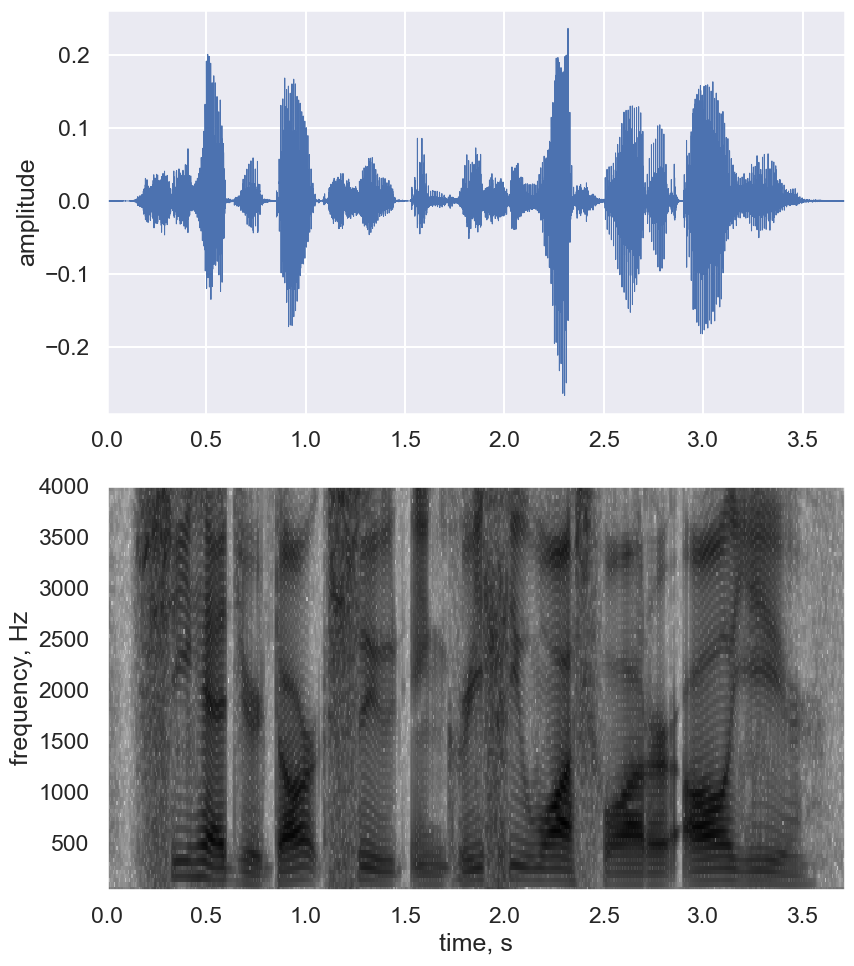

In [24]:
cse.displayData(int(cse.rate*25e-3), 0.75, True, 'dispdata.png')

In [25]:
cse.sampleCompressive(0.4, 1024, 0.75, "hann")

d:\kenneth\documents\vip\tf2_env\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10


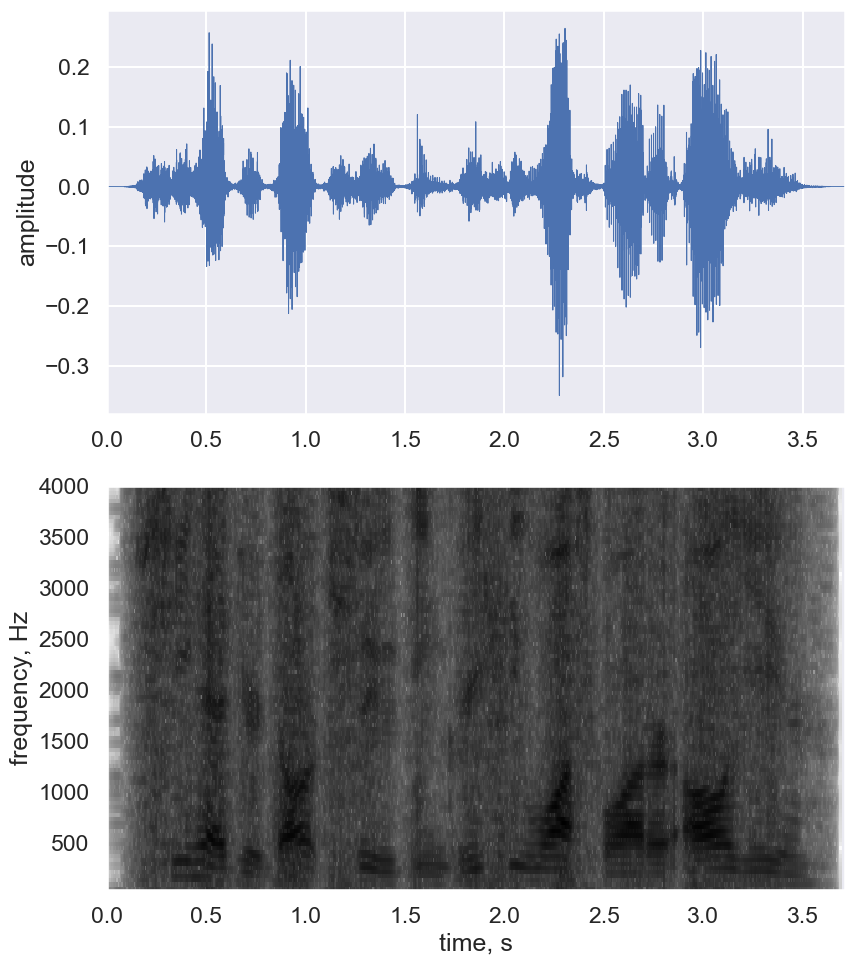

In [26]:
cse.displayRecovered(int(cse.rate*25e-3), 0.75, True, 'dispcomp.png')

In [28]:
print(pesq.pesq(cse.rate, cse.data, cse.xhat.real, 'nb'))
print(SNRseg(cse.data, cse.xhat.real, cse.starts, cse.seglen))

2.4313294887542725
0.07129240761491543


In [47]:
sf.write('SA1_recov.wav', cse.xhat.real.astype('float32'), cse.rate)

In [29]:
MNlist = np.arange(0.1, 1.0, 0.1)
sblist = [128, 256, 512, 1024]

pesqlist = np.zeros((len(MNlist), len(sblist)), float)
snrlist = np.zeros_like(pesqlist)

In [17]:
for i,s in enumerate(tqdm(sblist, desc="subband")):
    for j,m in enumerate(tqdm(MNlist, desc="compression ratio", leave=False)):
        cse = SpeechCS(r"D:\Kenneth\Documents\VIP\Algorithms\TIMIT\data\lisa\data\timit\raw\TIMIT\TEST\DR8\MJLN0\SA1.wav", 
                None, True, 8000)
        cse.sampleCompressive(m, s, 0.75, "hann")
        pesqlist[j,i] = pesq(cse.rate, cse.data, cse.xhat.real, "nb")
        snrlist[j,i] = SNRseg(cse.data, cse.xhat.real, cse.starts, cse.seglen)
np.save("pesq.npy", pesqlist)
np.save("snr.npy", snrlist)

D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.470266772125909e-11, tolerance: 1.5155717531930773e-11
  positive)


In [30]:
pesqlist = np.load("pesq.npy")
snrlist = np.load("snr.npy")

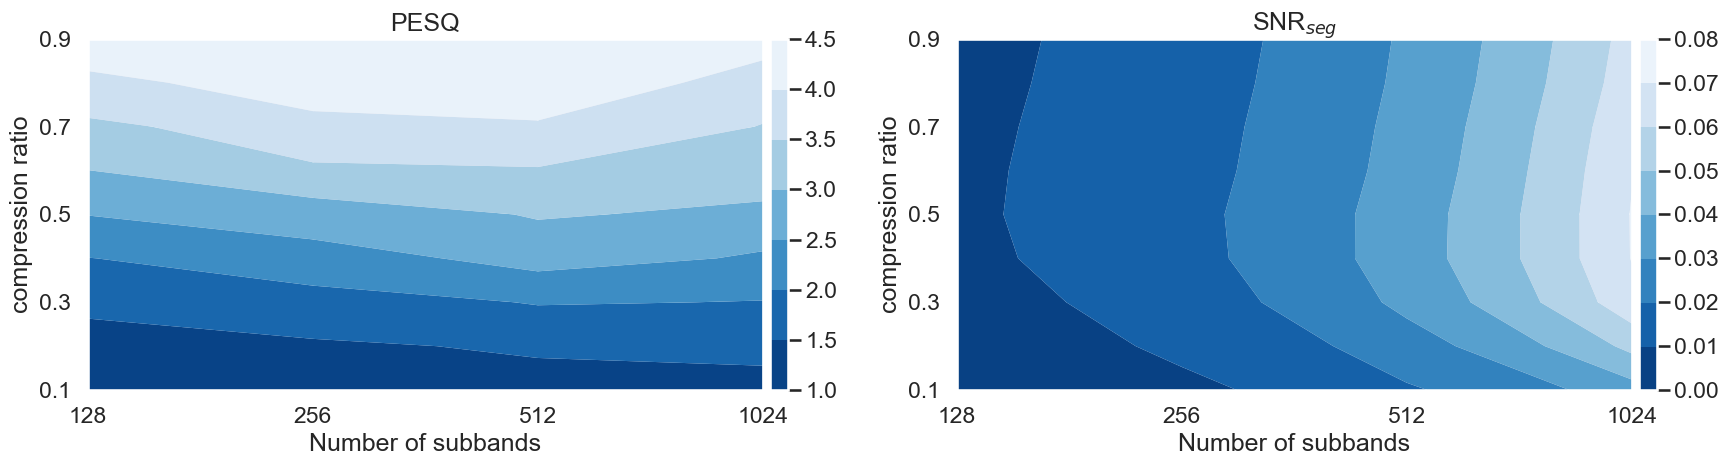

In [31]:
X, Y = np.meshgrid(sblist, MNlist)

fig = plt.figure(figsize=(5*16/9*2, 5))

# ax = fig.add_subplot(221, projection="3d")
# ax.view_init(elev=20, azim=-125)
# ax.set_xlabel("Number of subbands")
# ax.set_ylabel("compression ratio")
# ax.set_zlabel("PESQ")
# ax.set_xticks(sblist)
# ax.set_yticks(np.arange(0.1, 1.0, 0.2))
# norm = plt.Normalize(pesqlist.min(), pesqlist.max())
# colors = cm.jet(norm(pesqlist))
# rcount, ccount, _ = colors.shape
# surf = ax.plot_surface(X, Y, pesqlist, facecolors=colors, shade=False, rcount=rcount, ccount=ccount, linewidth=1, antialiased=True)
# surf.set_facecolor((1,1,1,1))

# ax = fig.add_subplot(222, projection="3d")
# ax.view_init(elev=20, azim=-125)
# ax.set_xlabel("Number of subbands")
# ax.set_ylabel("compression ratio")
# ax.set_zlabel("average $SNR_{seg}$")
# ax.set_xticks(sblist)
# ax.set_yticks(np.arange(0.1, 1.0, 0.2))
# norm = plt.Normalize(snrlist.min(), snrlist.max())
# colors = cm.jet(norm(snrlist))
# rcount, ccount, _ = colors.shape
# surf = ax.plot_surface(X, Y, snrlist, facecolors=colors, shade=False, rcount=rcount, ccount=ccount, linewidth=1, antialiased=True)
# surf.set_facecolor((1,1,1,1))

ax = fig.add_subplot(121)
cax = ax.contourf(X, Y, pesqlist, cmap="Blues_r", antialiased=True)
ax.set_xlabel("Number of subbands")
ax.set_ylabel("compression ratio")
ax.set_xticks(sblist)
ax.set_yticks(np.arange(0.1, 1.0, 0.2))
ax.set_xscale("log", basex=2)
ax.set_xticklabels([0, 128, 256, 512, 1024])
ax.set_title("PESQ")
fig.colorbar(cax, pad=0.01, fraction=0.1)

ax = fig.add_subplot(122)
cax = ax.contourf(X, Y, snrlist, cmap="Blues_r", antialiased=True)
ax.set_xlabel("Number of subbands")
ax.set_ylabel("compression ratio")
ax.set_xticks(sblist)
ax.set_yticks(np.arange(0.1, 1.0, 0.2))
ax.set_xscale("log", basex=2)
ax.set_xticklabels([0, 128, 256, 512, 1024])
ax.set_title("SNR$_{seg}$")
fig.colorbar(cax, pad=0.01, fraction=0.1)

# plt.suptitle("clean signal")
plt.tight_layout()
plt.savefig("metrics.png", bbox_inches="tight", dpi=300)
plt.show()